# **NLP analysis on top artsts' lyrics**

What to we want with NLP analysis?

> Easy thing is to find common words and themes (REMEMBER we are given the genre attribute already).\
> Can NLP account for the mood and sentiment? Even if it is a love song, it could be very sad.\
> Do artists in the same genre also use similar words?\
> Do artists who use similar words tend to collaborate more often? (or artist with the same sentiment and mood)\
> Can genre be guessed from lyrics and sentiment?\
> We also see how well do artists actually represent their genres IF genres can be guessed from lyrics alone? - like sometimes it genre is more a "sound, music" style rather than lyrical style.

Definitions:
> Artist sentiment is the average of the top 5 songs.

Things we should be careful of:
> Since we take artists above a popularity threshold - we should address that this analysis may be limited or closed off.\
> REMEMBER: we already have genres as attributes but the NLP does not know it ofc.

### Imports

In [173]:
import os
import math
from collections import defaultdict
from collections import Counter
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm as tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import time
from collections import deque
# from openai import OpenAI
import ast
import nltk
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

load_dotenv()

SPOTIFY_API_KEY = os.getenv("SPOTIFY_API_KEY_3")
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID_3")
GENIUS_TOKEN = os.getenv("GENIUS_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

TOP_100_PLAYLIST_ID = "0sDahzOkMWOmLXfTMf2N4N"
TIKTOK_PLAYLIST_ID = "57EG9lWmdn7HHofXuQVsow"

auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_API_KEY)
sp = spotipy.Spotify(auth_manager=auth_manager)
#llm = OpenAI(api_key=OPENAI_API_KEY)

In [24]:
def load_checkpoint(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

def save_checkpoint(filename, graph, frontier, node_attributes, artist_ids, current_depth):
    with open(filename, 'wb') as f:
        pickle.dump({
            'graph': graph,
            'frontier': frontier,
            'node_attributes': node_attributes,
            'artist_ids': artist_ids,
            'current_depth': current_depth
        }, f)

In [25]:
data_cleaned = load_checkpoint('data_final_cleaned_depth_2.pkl')
graph_cleaned = data_cleaned['graph']
node_attributes = data_cleaned['node_attributes']

We already have the top 5 songs that present Spotify’s official top tracks for each artist ranked by Spotify’s popularity algorithm. For these songs, there are NO random album cuts.

In [20]:
node_attributes['Doja Cat']['top_5_tracks']

[{'name': 'Kiss Me More (feat. SZA)',
  'popularity': 85,
  'lyrics': "2 Contributors\nNew Music Friday 4/9/21 Lyrics\nEvery Friday, Spotify compiles the hottest and most notable recent releases. If you want to discover new music and keep up with the freshest songs, listen to the playlist below and read the annotated lyrics.\n… \nRead More\n\xa0\nKiss Me More (feat. SZA) - Doja Cat\nOtra Noche Sin Ti - J Balvin\nMr. Perfectly Fine (Taylor’s Version) (From The Vault) - Taylor Swift\nShy Away - Twenty One Pilots\nRAPSTAR - Polo G\nBANKROLL (feat. A$AP Rocky & A$AP Ferg) - BROCKHAMPTON\nSet Him Up (feat. Ari Lennox) - Queen Naija\nStarstruck - Years & Years\nWaves of Blue - Majid Jordan\nNobody But You - Sonder\nFreedom (with BEAM) - Justin Bieber\nWave of You - Surfaces\nSurvivor - KNOWN.\nWhipski (feat. Lil Skies & Internet Money) - $NOT\nShow Me Up - Lil Tecca\nAmor en Coma - Manuel Turizo\nSunset - Demi Lovato\nHaunted House - Holly Humberstone\nAnywhere Away From Hеre (Rag’n’Bone Man

## **Common words and themes**

Start with cleaning.

In [151]:
from langdetect import detect, LangDetectException

def clean_raw_lyrics(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\d+\s+Contributors', '', text)
    text = re.sub(r'Translations', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(Deutsch|Español|Türkçe|Русский|Česky|Français|Nederlands|Italiano|简体中文|ไทย)\b', '', text)
    text = re.sub(r'Read More', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\[.*?\]', '', text) # For those [Chorus], [Verse] and so on 
    text = re.sub(r'[\xa0]', ' ', text) # non-breaking space
    text = re.sub(r'New Music Friday.*?Lyrics', '', text, flags=re.DOTALL)
    text = re.sub(r'[A-Z].+? - .+?\n', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = text.encode('ascii', errors='ignore').decode()
    text = re.sub(r'\n+', '\n', text)


    return text.strip()

def valid_lyrics(text):
    if not isinstance(text, str):
        return False

    if len(text.split()) > 1500:
        return False

    if text.lower().count("feat") > 8:
        return False
    
    return True

def keep_if_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:

        return False

# Our clean lyrics:
for artist, attrs in node_attributes.items():
    cleaned = []
    for track in attrs.get("top_5_tracks", []):
        raw = track.get("lyrics", "")
        cleaned_text = clean_raw_lyrics(raw)

        if not cleaned_text:
            continue
        if not valid_lyrics(cleaned_text):
            continue
        if not keep_if_english(cleaned_text):
            continue

        # store the cleaned version
        track["lyrics"] = cleaned_text
        cleaned.append(track)

    attrs["top_5_tracks"] = cleaned

# With inspiration from week 7, we start building our corpus of lyrics.
lyrics_corpus = {}

for artist, attrs in node_attributes.items():
    tracks = attrs.get("top_5_tracks", [])
    text = " ".join([track["lyrics"] for track in tracks if track["lyrics"]])
    lyrics_corpus[artist] = text

# Make sure no names appear in lyrics for instance, the lyrics extractor failed do filter for "[chorus - Taylor Swift]" and such:
all_artist_names = set(node_attributes.keys())
name_blacklist = set()

for name in all_artist_names:
    parts = name.lower().split()
    for p in parts:
        if len(p) > 2:
            name_blacklist.add(p)
    if len(name) > 2:
        name_blacklist.add(name.lower())

# Remove artist names from lyrics corpus
for artist, text in lyrics_corpus.items():
    words = text.split()
    filtered = [w for w in words if w.lower() not in name_blacklist]
    lyrics_corpus[artist] = " ".join(filtered)

# So for instance, now Doja cat will have her name: song lyrics... song lyrics...

Stop words and tokenizing the lyrics.

In [152]:
stop_words = set(stopwords.words("english"))

def preprocess(text):
    if not isinstance(text, str):
        return []

    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    return tokens

cleaned_lyrics = {artist: preprocess(text) for artist, text in lyrics_corpus.items()}

### TF-IDF calculations (from week 7)

In [153]:
artist_TFs = {artist: Counter(tokens) for artist, tokens in cleaned_lyrics.items()}

N = len(artist_TFs)  
word_df = defaultdict(int)

for counts in artist_TFs.values():
    for word in counts:
        word_df[word] += 1

artist_TFIDF = {}

for artist, counts in artist_TFs.items():
    tfidf = {}
    for word, tf in counts.items():
        df = word_df[word]
        idf = math.log(N / (1 + df))  
        tfidf[word] = tf * idf
    artist_TFIDF[artist] = tfidf

### Word clouds

We have to filter out some artists, as we cannot have 800+ wordclouds... For this filtering, we investigate the popularity attribute of each artist node and only keep those above a certain threshold. This way, we can focus on the more popular artists in the network. 

In [154]:
# First we find the mean:

popularity_values = [attrs.get("popularity", 0) for attrs in node_attributes.values()]
mean_popularity = sum(popularity_values) / len(popularity_values)
popularity_75 = sorted(popularity_values)[int(0.75 * len(popularity_values))]

# We investigate the number of artists above mean popularity
above_mean_popularity = [artist for artist, attrs in node_attributes.items() if attrs.get("popularity", 0) > popularity_75]
len(above_mean_popularity)

193

Still too many...

We restrict analysis to the top decile of artists by popularity to ensure each artist has sufficient cultural relevance and consistent lyric availability.

In [155]:
# Top 10 most popular artists:
artists_with_lyrics = {
    artist: attrs for artist, attrs in node_attributes.items()
    if len(attrs.get("top_5_tracks", [])) > 0
}

# Now sort those by popularity
top_10_popular_artists = sorted(
    artists_with_lyrics.items(),
    key=lambda x: x[1].get("popularity", 0),
    reverse=True
)[:10]

top_10 = [artist for artist, _ in top_10_popular_artists]
top_10
# We have to filter for language and those who have lyrics.

['Taylor Swift',
 'Drake',
 'The Weeknd',
 'Sabrina Carpenter',
 'Billie Eilish',
 'Justin Bieber',
 'Ariana Grande',
 'Rihanna',
 'Travis Scott',
 'KPop Demon Hunters Cast']

When we requested API, we did the US region. This could explain maybe why some spanish artists - Bad Bunny and Fuerza Regida were amongst the top 10 popular, but since we filtered for english only to maintain consistency in NLP, they were dropped. But it makes sense that they are popular in the US region, maybe like US southern states with more hispanic population?

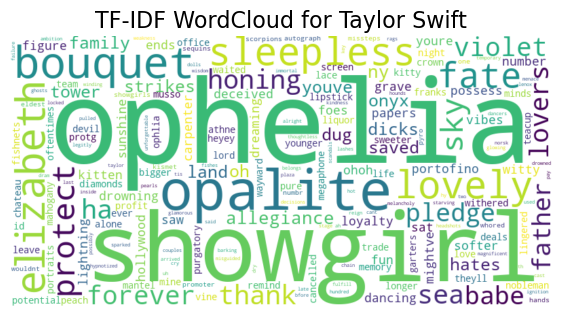

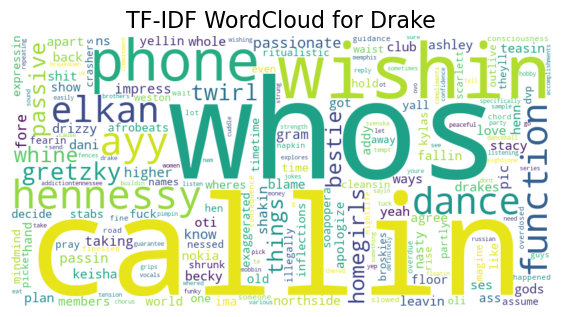

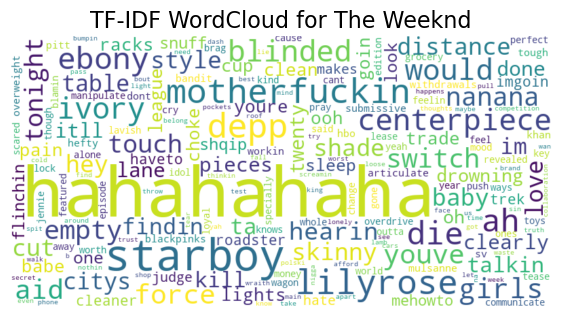

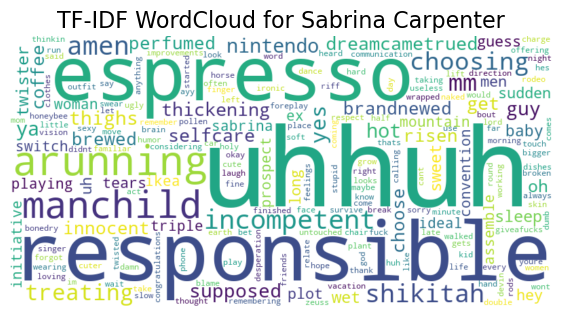

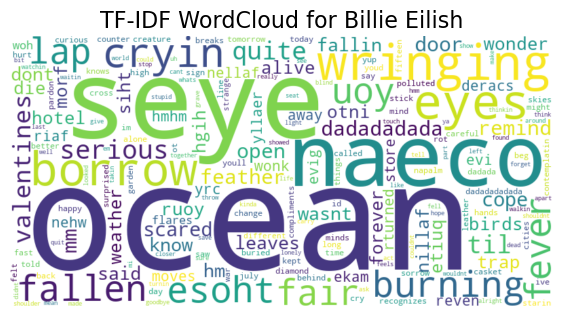

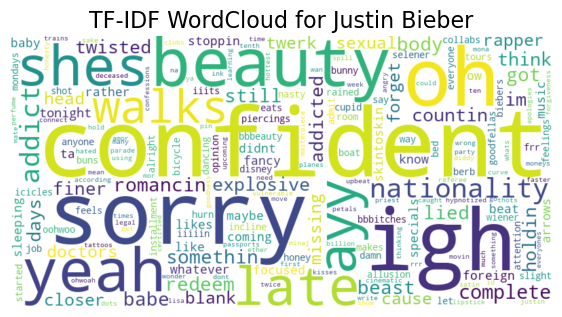

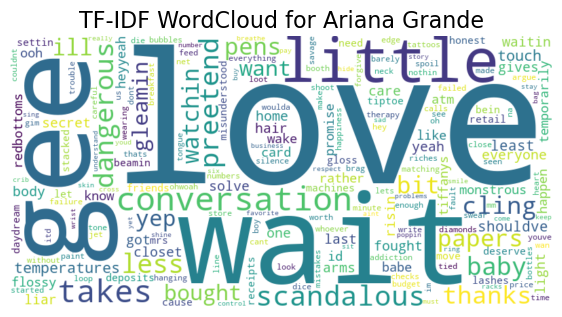

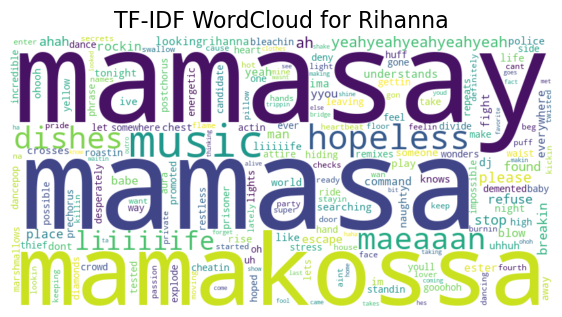

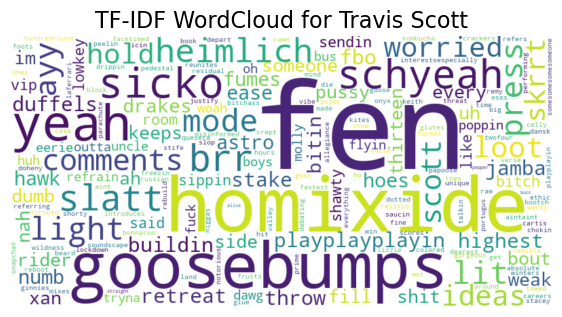

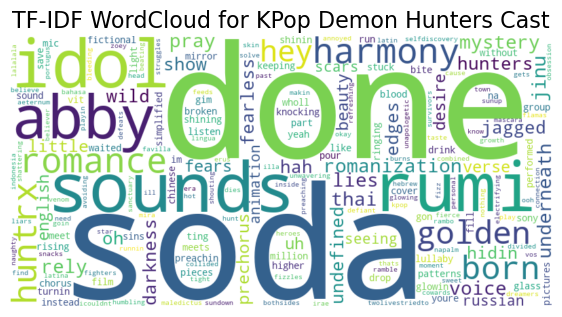

In [156]:
# Now for TF-IDF word clouds:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for artist in top_10:
    scores = artist_TFIDF.get(artist, {})
    if not scores:
        continue

    max_score = max(scores.values())
    scaled_scores = {w: (v / max_score) * 100 for w, v in scores.items()}

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False
    ).generate_from_frequencies(scaled_scores)

    plt.figure(figsize=(7,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"TF-IDF WordCloud for {artist}", fontsize=16)
    plt.show()

Here, we can deduct:

> Which themes dominate in each artist’s lyrics?\
>  Are genres cluster around similar word choices?\
> Whether certain artists stand out (unique vocabulary)


## **Sentiment analysis using VADER**

In [162]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {"pos": 0, "neu": 0, "neg": 0, "compound": 0}
    return analyzer.polarity_scores(text)

# Now we add sentiment to each artist track:
for artist in top_10:
    for track in node_attributes[artist].get("top_5_tracks", []):
        track["sentiment"] = compute_sentiment(track["lyrics"])

# Appending everything into a dictionary:
artist_sentiment = {}

for artist in top_10:
    tracks = node_attributes[artist].get("top_5_tracks", [])
    sentiments = [t["sentiment"] for t in tracks if "sentiment" in t]

    if len(sentiments) == 0:
        artist_sentiment[artist] = None
        continue

    artist_sentiment[artist] = {
        "pos": float(np.mean([s["pos"] for s in sentiments])),
        "neu": float(np.mean([s["neu"] for s in sentiments])),
        "neg": float(np.mean([s["neg"] for s in sentiments])),
        "compound": float(np.mean([s["compound"] for s in sentiments])),
    }

artist_sentiment

{'Taylor Swift': {'pos': 0.13679999999999998,
  'neu': 0.7622,
  'neg': 0.1008,
  'compound': 0.1969},
 'Drake': {'pos': 0.16760000000000003,
  'neu': 0.7564000000000001,
  'neg': 0.076,
  'compound': 0.6442399999999999},
 'The Weeknd': {'pos': 0.07075000000000001,
  'neu': 0.7422500000000001,
  'neg': 0.18675,
  'compound': -0.9031},
 'Sabrina Carpenter': {'pos': 0.13175,
  'neu': 0.8075000000000001,
  'neg': 0.060750000000000005,
  'compound': 0.96025},
 'Billie Eilish': {'pos': 0.12449999999999999,
  'neu': 0.7807499999999999,
  'neg': 0.095,
  'compound': -0.30757500000000004},
 'Justin Bieber': {'pos': 0.13840000000000002,
  'neu': 0.7532,
  'neg': 0.10840000000000001,
  'compound': 0.5642600000000001},
 'Ariana Grande': {'pos': 0.22725,
  'neu': 0.696,
  'neg': 0.0765,
  'compound': 0.045575000000000004},
 'Rihanna': {'pos': 0.21680000000000002,
  'neu': 0.7,
  'neg': 0.0834,
  'compound': 0.6003200000000001},
 'Travis Scott': {'pos': 0.1525,
  'neu': 0.7697499999999999,
  'neg':

Notes about scoring from the [official VADER documentation](https://github.com/cjhutto/vaderSentiment):

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

> positive sentiment: compound score $>= 0.05$\
> neutral sentiment: (compound score $> -0.05$) and (compound score $< 0.05$)\
> negative sentiment: compound score $<= -0.05$


### Interpretations of VADER sentiment scores

Right now, we are looking at each artist's compound score.

> **Taylor Swift** has a score of $0.1969$, aligns with her songs being mildly positive but still emotionally mixed (as expected for breakup and nostalgia pop).\
> **Drake** has a score of $0.6442$, has a stronger positive compound, because Drake writes a lot of confidence, flexing or self-worth lyrics.\
> **The Weeknd** is very negative with $-0.9031$, as his lyrics are mostly toxic relationships, heartbreak and self-destructive behavior (drugs and regret).\
> **Sabrina Carpenter** is very positive with $0.96025$, as her lyrics are mostly upbeat, sarcastic songs about love and men.\
> **Billie Eilish** is more negative with $-0.307575$, fitting with her dark, moody lyrics about mental health, loneliness and self-reflection.\
> **Justin Bieber** is positive $0.56426$, fits with romantic and uplifting themes in his songs.\
> **Ariana Grande** has a score of $0.04557$ with heavy romance positivity, heartbreak themes and some sexual themes (neutral to positive).\
> **Rihanna** has a score of $0.6003$, with many empowering and confident themes like shine bright like a diamond.\
> **Travis Scott** has a score of $0.516775$ which is positive, since via VADER, bragging is a theme in his songs, and it is seen as “positive” according to VADER.\
> **KPop Demon Hunters Cast** has a score of $0.23216$, which makes sense as their top songs both contain the themes of the villain which might be seen as negative, but they also have the heroic songs, pulling the score up to mildly positive.

What to see from this? Why sentiment analysis? Because, for instance, two love songs might both be "romantic", but one is sad and one is upbeat. But here, sentiment catches that.


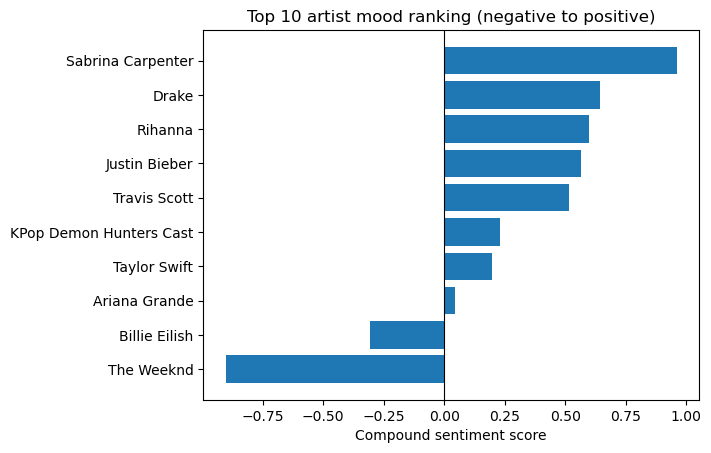

In [168]:
# Sort by compound score:
artist_names = list(artist_sentiment.keys())
compound_scores = [artist_sentiment[a]["compound"] for a in artist_names]
sorted_idx = np.argsort(compound_scores)
sorted_artists = [artist_names[i] for i in sorted_idx]
sorted_scores = [compound_scores[i] for i in sorted_idx]

plt.barh(sorted_artists, sorted_scores)
plt.xlabel("Compound sentiment score")
plt.title("Top 10 artist mood ranking (negative to positive)")
plt.axvline(0, color="black", linewidth=0.8)
plt.show()


## **Do artists in the same genres have similar words?**

This is to find out if genre is defined lyrically or more by sound and music style.

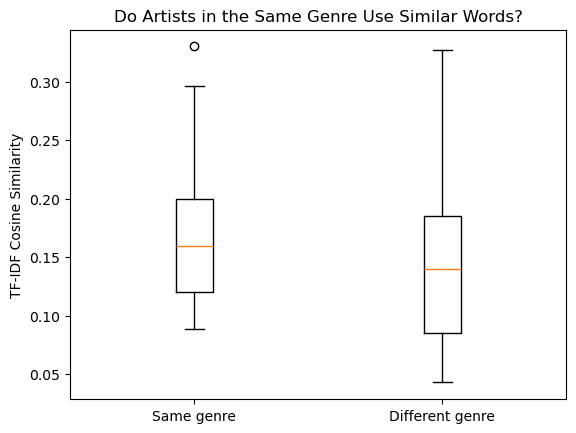

Average same-genre similarity: 0.17578290169569702
Averagae diff-genre similarity: 0.14553461777079205


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Again we ONLY keep the top 10 most popular artists:
# (inspired by week 7)
top10_corpus = {artist: lyrics_corpus[artist] for artist in top_10}
artists = list(top10_corpus.keys())
documents = list(top10_corpus.values())

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(documents)  

sim_matrix = cosine_similarity(X) # 10x10

# EXTRACT GENRES:
artist_genre = {artist: node_attributes[artist]["genres"][0] for artist in top_10}

same_genre_sims = []
diff_genre_sims = []

for i in range(len(artists)):
    for j in range(i+1, len(artists)):
        a1, a2 = artists[i], artists[j]
        sim = sim_matrix[i][j]

        if artist_genre[a1] == artist_genre[a2]:
            same_genre_sims.append(sim)
        else:
            diff_genre_sims.append(sim)

# Now we can plot:
plt.boxplot([same_genre_sims, diff_genre_sims], tick_labels=["Same genre", "Different genre"])

plt.ylabel("TF-IDF Cosine Similarity")
plt.title("Do Artists in the Same Genre Use Similar Words?")
plt.show()

print("Average same-genre similarity:", sum(same_genre_sims)/len(same_genre_sims))
print("Averagae diff-genre similarity:", sum(diff_genre_sims)/len(diff_genre_sims))

Why do we investigate this? Because it could be interesting to see if genres are lyrically defined (like what style of writing, words they use), or is genres more musically defined? Therefore, we measure how close aretists are to others in their matching genres. To clarify the problem also, one could ask if pop songs always happy and rap songs more aggresive and dark? Or is it more complicated than that?

## **Sentiment by genre analysis**

In [198]:
import pandas as pd

rows = []

for artist in top_10:   # restrict to your analysis subset
    sentiment = artist_sentiment.get(artist)
    if sentiment is None:
        continue

    genres = node_attributes[artist].get("genres", [])
    if not genres:
        continue

    main_genre = genres[0]  # consistent with earlier

    rows.append({
        "artist": artist,
        "genre": main_genre,
        "pos": sentiment["pos"],
        "neu": sentiment["neu"],
        "neg": sentiment["neg"],
        "compound": sentiment["compound"]
    })

df_sent = pd.DataFrame(rows)
df_sent

,artist,genre,pos,neu,neg,compound
0,Taylor Swift,pop,0.13680,0.76220,0.10080,0.196900
1,Drake,rap,0.16760,0.75640,0.07600,0.644240
2,The Weeknd,alternative r&b,0.07075,0.74225,0.18675,-0.903100
3,Sabrina Carpenter,pop,0.13175,0.80750,0.06075,0.960250
4,Billie Eilish,pop,0.12450,0.78075,0.09500,-0.307575
5,Justin Bieber,pop,0.13840,0.75320,0.10840,0.564260
6,Ariana Grande,pop,0.22725,0.69600,0.07650,0.045575
7,Rihanna,pop,0.21680,0.70000,0.08340,0.600320
8,Travis Scott,rap,0.15250,0.76975,0.07750,0.516775
9,KPop Demon Hunters Cast,k-pop,0.13940,0.76300,0.09760,0.232160


In [199]:
genre_sentiment = df_sent.groupby("genre")[["pos", "neu", "neg", "compound"]].mean()
genre_sentiment

,pos,neu,neg,compound
genre,,,,
alternative r&b,0.070750,0.742250,0.186750,-0.903100
k-pop,0.139400,0.763000,0.097600,0.232160
pop,0.162583,0.749942,0.087475,0.343288
rap,0.160050,0.763075,0.076750,0.580507


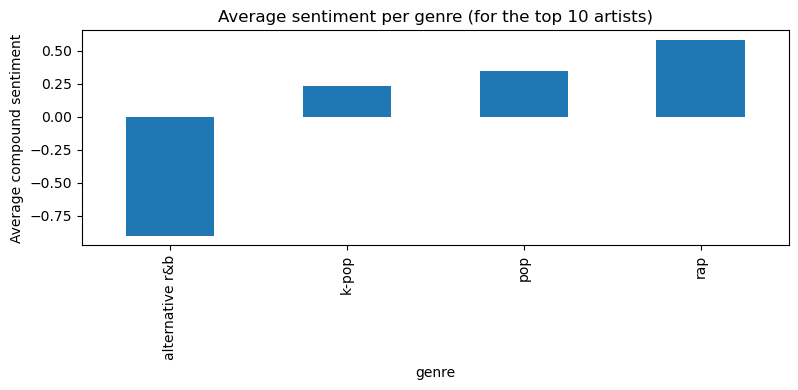

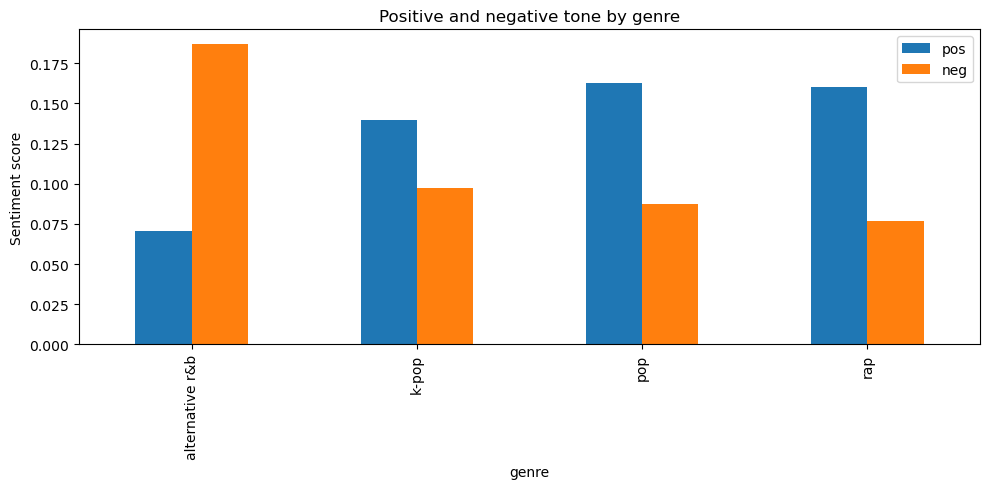

In [203]:
plt.figure(figsize=(8,4))
genre_sentiment["compound"].plot(kind="bar")
plt.ylabel("Average compound sentiment")
plt.title("Average sentiment per genre (for the top 10 artists)")
plt.tight_layout()
plt.show()

genre_sentiment[["pos", "neg"]].plot(kind="bar", figsize=(10,5))
plt.title("Positive and negative tone by genre")
plt.ylabel("Sentiment score")
plt.tight_layout()
plt.show()

Here, we computed VADER sentiment scores for the lyrics of each artist’s top tracks, and then averaged these scores at genre level. This shows how certain genres are lyrically more positive, neutral, negative, or emotionally intense.

We see that alternative r&b is dominated by negative sentiment, meanwhile k-pop is neutral (slightly more positive), and pop and rap are more positive overall. But more surprisingly, Pop is more positive than rap BUT it is also bore negative than rap, hence, giving pop a bit narrower average compound range. Moreover, rap came out to be the most positive genre on average.

THOUGH, we have to be careful, because we only used the top 10 most popular artists to represent the genres, hence, this is a very limited sample size and may not represent the entire genre accurately.

## **Important notes on limitations of this analysis**

> We only include artists above a popularity threshold (bias), aka we take the top 10 most popular artists, so this becomes much more limited.\
> Some artists don’t have lyric data, but this is unavoidable, maybe this is proportional to popularity as well.\
> Some genres are non-lyrical (EDM, instrumental, experimental).\
> Lyrics from Genius may contain noise or wrong formatting but we handled that in the cleaning step.\
> Sentiment models struggle with slang, metaphors, and multilingual text.\
> We also do not translate, hence, we focusing on english lyrics only.